## CNN-CIFAR-10

It consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

5 Training batches and 1 Test batch. Each containing 1000 images

**Downloading the CIFAR-10 dataset** https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz 

In [149]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
import numpy as np
import time

In [150]:
CIFAR_DIR = r'C:\Users\Noushin\Downloads\Compressed\cifar-10-batches-py/'

In [151]:
CIFAR_DIR

'C:\\Users\\Noushin\\Downloads\\Compressed\\cifar-10-batches-py/'

In [152]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        cifar_dict = pickle.load(fo, encoding='bytes')
    return cifar_dict

In [153]:
dirs = ['batches.meta','data_batch_1','data_batch_2','data_batch_3','data_batch_4','data_batch_5','test_batch']
#dirs = ['batches.meta','data_batch_1','data_batch_2','test_batch']

In [154]:
all_data = [0,1,2,3,4,5,6]
#all_data = [0,1,2,3]

In [155]:
for i,direc in zip(all_data,dirs):
    all_data[i] = unpickle(CIFAR_DIR+direc)

In [156]:
batch_meta = all_data[0]
data_batch1 = all_data[1]
data_batch2 = all_data[2]
data_batch3 = all_data[3]
data_batch4 = all_data[4]
data_batch5 = all_data[5]
test_batch = all_data[6]


In [157]:
#data_batch1.keys() 
#data_batch1.values()

Loaded in this way, each of the batch files contains a dictionary with the following elements:
* data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
* labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:

* label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.

### Display a single image using matplotlib.


In [158]:
X = data_batch1[b"data"] 

In [159]:
X.shape

(10000, 3072)

In [160]:
X = X.reshape(10000, 3, 32, 32).transpose(0,2,3,1).astype("uint8")

In [161]:
X.shape

(10000, 32, 32, 3)

In [162]:
X[0].shape

(32, 32, 3)

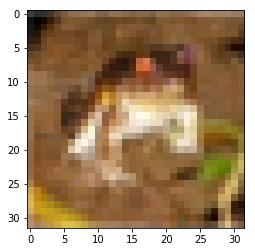

In [163]:
plt.imshow(X[0])

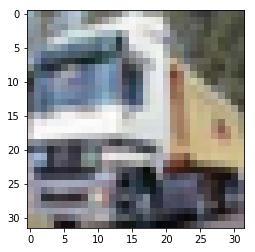

In [164]:
plt.imshow(X[1])

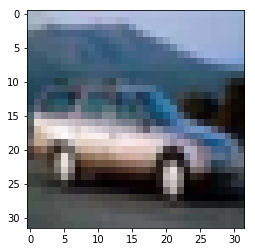

In [165]:
plt.imshow(X[4])

# Helper Functions:

In [166]:
def one_hot_encode(vec, vals=10):
    n = len(vec)
    out = np.zeros((n, vals))
    out[range(n), vec] = 1
    return out

In [167]:
def one_hot_to_names(vec):
    
    names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    out = names[np.argmax(vec)]
    return out

In [168]:
print(one_hot_to_names([0,0,0,0,0,0,0,0,1,0]))

ship


In [169]:
class CifarHelper():
    
    def __init__(self):
        self.i = 0
        
        #self.all_train_batches = [data_batch1,data_batch2,data_batch3,data_batch4,data_batch5]
        self.all_train_batches = [data_batch1,data_batch2]
        self.test_batch = [test_batch]
        
        self.training_images = None
        self.training_labels = None
        
        self.test_images = None
        self.test_labels = None
    
    def set_up_images(self):
        
        print("Setting Up Training Images and Labels")
        
        self.training_images = np.vstack([d[b"data"] for d in self.all_train_batches])
        train_len = len(self.training_images)
        
        self.training_images = self.training_images.reshape(train_len,3,32,32).transpose(0,2,3,1)/255
        self.training_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.all_train_batches]), 10)
        
        print("Setting Up Test Images and Labels")
        
        self.test_images = np.vstack([d[b"data"] for d in self.test_batch])
        test_len = len(self.test_images)
        
        self.test_images = self.test_images.reshape(test_len,3,32,32).transpose(0,2,3,1)/255
        self.test_labels = one_hot_encode(np.hstack([d[b"labels"] for d in self.test_batch]), 10)

        
    def next_batch(self, batch_size):
        x = self.training_images[self.i:self.i+batch_size].reshape(100,32,32,3)
        y = self.training_labels[self.i:self.i+batch_size]
        self.i = (self.i + batch_size) % len(self.training_images)
        return x, y

In [170]:
# Before tf.Session
ch = CifarHelper()
ch.set_up_images()

Setting Up Training Images and Labels
Setting Up Test Images and Labels


## Creating the Model


In [171]:
import tensorflow as tf

In [172]:
x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,10])

In [173]:
#hold_prob = tf.placeholder(tf.float32)

In [174]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

#def max_pool_2by2(x):
#    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          #strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

In [175]:
convo_1 = convolutional_layer(x,shape=[3,3,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [176]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[3,3,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [177]:
convo_3 = convolutional_layer(convo_2_pooling,shape=[3,3,64,128])
convo_3_pooling = max_pool_2by2(convo_3)

In [178]:
convo_3_flat = tf.reshape(convo_3_pooling,[-1,32*32*128])

In [179]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_3_flat,1024))

In [180]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [181]:
y_pred = normal_full_layer(full_one_dropout,10)

### Loss Function

In [182]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

### Optimizer

In [183]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.0005)
train = optimizer.minimize(cross_entropy)

In [186]:
init = tf.global_variables_initializer()

## Graph Session

In [187]:
#with tf.Session() as sess:
strt = time.time()
sess = tf.Session() 
sess.run(tf.global_variables_initializer())

for i in range(5000):

    batch = ch.next_batch(100)
    sess.run(train, feed_dict={x: batch[0], y_true: batch[1]})
    
    # PRINT OUT A MESSAGE EVERY 100 STEPS
    if i%100 == 0:
        
        print('Currently on step {}'.format(i))
        print('Accuracy is:')
        # Test the Train Model
        matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

        acc = tf.reduce_mean(tf.cast(matches,tf.float32))

        print(sess.run(acc,feed_dict={x:ch.test_images,y_true:ch.test_labels}))
        print('\n')
        
endd = time.time()
print(int(endd - strt)//60)

Currently on step 0
Accuracy is:
0.1


Currently on step 100
Accuracy is:
0.4004


Currently on step 200
Accuracy is:
0.4219


Currently on step 300
Accuracy is:
0.4717


Currently on step 400
Accuracy is:
0.4888


1555987970.3309493
1555990838.3966384
47


# Visualizing the Network

In [201]:
def getActivations(layer,stimuli):
    #units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,784],order='F'),keep_prob:1.0})   
    units = sess.run(layer,feed_dict={x:np.reshape(stimuli,[1,32,32,3],order='F')})
    plotNNFilter(units)

In [192]:
def plotNNFilter(units):
    filters = units.shape[3]
    plt.figure(1, figsize=(20,20))
    n_columns = 6
    n_rows = math.ceil(filters / n_columns) + 1
    for i in range(filters):
        plt.subplot(n_rows, n_columns, i+1)
        plt.title('Feature map ' + str(i))
        plt.imshow(units[0,:,:,i], interpolation="nearest")


Now we can choose an image to pass through the network to visualize the network activation, and look at the raw pixels of that image.

deer


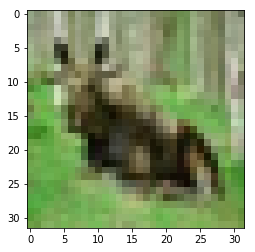

In [210]:
intrested_img = 1249
imageToUse = ch.test_images[intrested_img]
print(one_hot_to_names(ch.test_labels[intrested_img]))
plt.imshow(np.reshape(imageToUse,[32,32,3]), interpolation="nearest")

Now we can look at how that image activates the neurons of the first convolutional layer. Notice how each filter has learned to activate optimally for different features of the image.

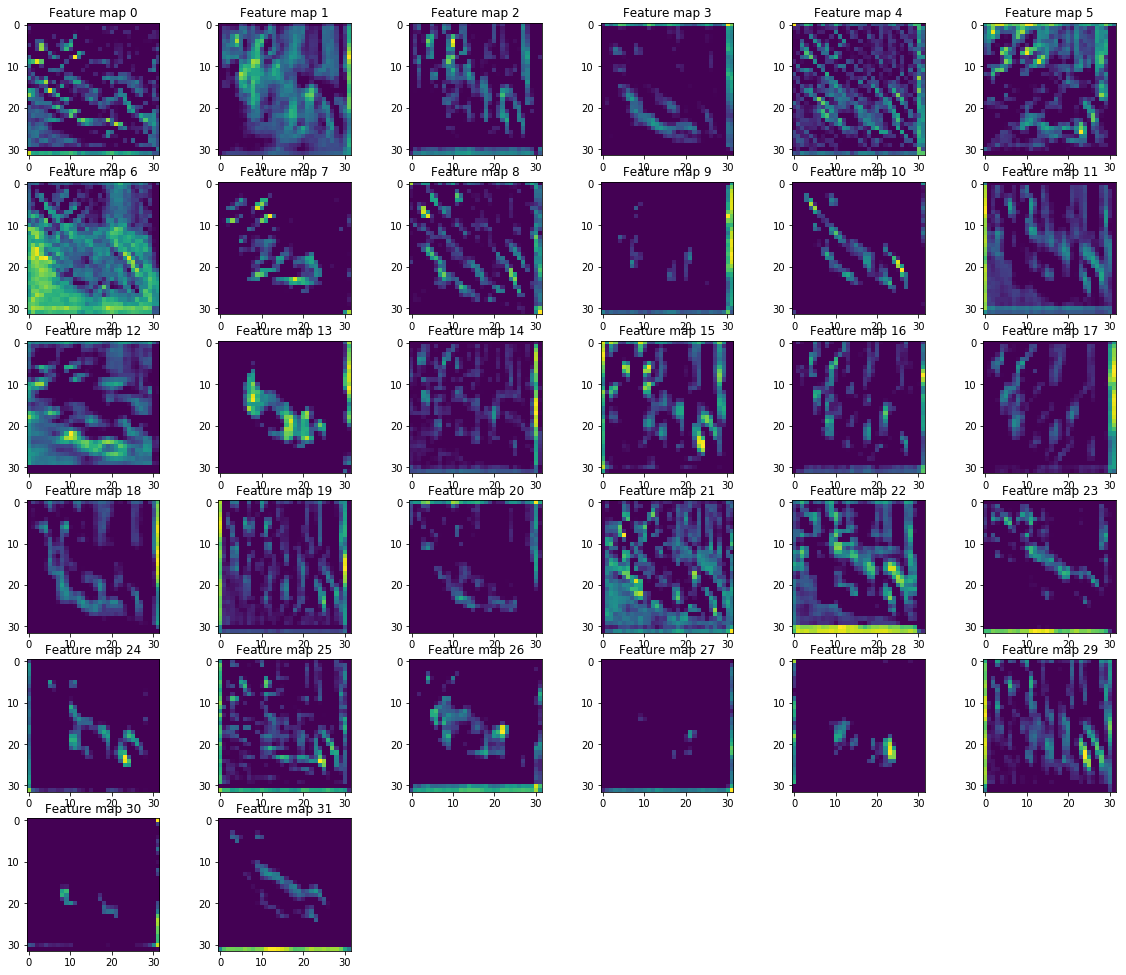

In [211]:
getActivations(convo_1,imageToUse)


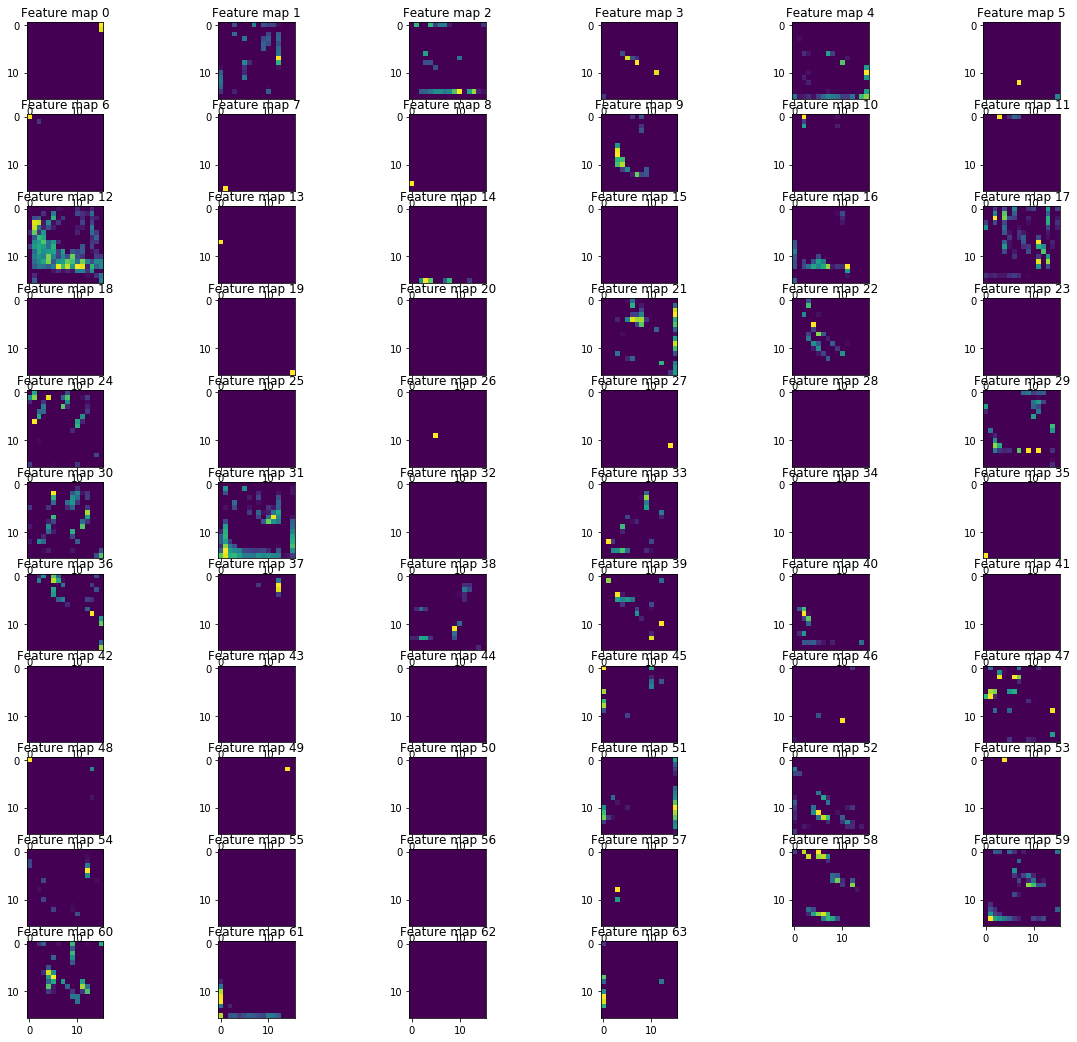

In [212]:
getActivations(convo_2,imageToUse)


In [213]:
test_out_y = sess.run(y_pred, feed_dict={x:ch.test_images,y_true:ch.test_labels, hold_prob:1.0})

In [214]:
test_out_y.shape 

(10000, 10)

In [215]:
print(test_out_y[intrested_img])
one_hot_to_names(test_out_y[intrested_img] )

[ -6.2304764   -6.1097646   -0.24367991   1.3290589    7.1054683
   3.2464561    0.9791793    4.897126   -12.213736    -3.2023022 ]


'deer'

<BarContainer object of 10 artists>

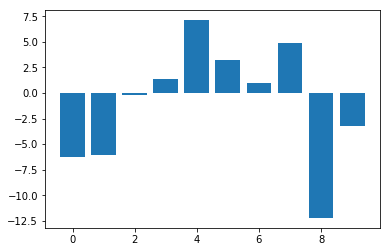

In [216]:
plt.bar(np.arange(len(test_out_y[intrested_img])), test_out_y[intrested_img])
